# VAE Model for LFW

## Environment Setup

In [1]:
import sys
sys.path.append("/Users/kr/Library/Python/3.11/lib/python/site-packages")
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages")
from dataset import get_data,normalize
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## VAE Model

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        
        # Latent space layers
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, 32 * 8 * 8)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)
        
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        
        return mean, logvar
    
    def decode(self, z):
        x = F.relu(self.fc2(z))
        x = F.relu(self.fc3(x))
        x = x.view(x.size(0), 32, 8, 8)
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        
        return x
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar

## Hyper-Parameter Setup

In [3]:
# 定义模型超参数
latent_dim = 120
learning_rate = 0.001
num_epochs = 500
batch_size = 32

In [4]:
model = VAE(latent_dim)

## Loss Function and Optimizer

In [5]:
# 定义损失函数和优化器
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 载入数据集
X_train = get_data('dataset')

# 将数据集转换为Tensor
X_train = torch.Tensor(X_train)

# 创建数据加载器
data_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

## Training

In [8]:
# 训练模型
total_steps = len(data_loader)
for epoch in range(num_epochs):
    for i, images in enumerate(data_loader):
        # 前向传播
        recon_images, mean, logvar = model(images)
        
        # 计算重构误差和KL散度
        recon_loss = criterion(recon_images, images)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        
        # 计算总损失
        loss = recon_loss + 1e-5 * kl_loss
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 打印训练信息
        if (epoch+1) % 10 == 0 and (i+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}")

Epoch [10/500], Step [10/32], Loss: 0.0447
Epoch [10/500], Step [20/32], Loss: 0.0338
Epoch [10/500], Step [30/32], Loss: 0.0387
Epoch [20/500], Step [10/32], Loss: 0.0356
Epoch [20/500], Step [20/32], Loss: 0.0350
Epoch [20/500], Step [30/32], Loss: 0.0346
Epoch [30/500], Step [10/32], Loss: 0.0362
Epoch [30/500], Step [20/32], Loss: 0.0324
Epoch [30/500], Step [30/32], Loss: 0.0344
Epoch [40/500], Step [10/32], Loss: 0.0315
Epoch [40/500], Step [20/32], Loss: 0.0315
Epoch [40/500], Step [30/32], Loss: 0.0309
Epoch [50/500], Step [10/32], Loss: 0.0315
Epoch [50/500], Step [20/32], Loss: 0.0338
Epoch [50/500], Step [30/32], Loss: 0.0311
Epoch [60/500], Step [10/32], Loss: 0.0322
Epoch [60/500], Step [20/32], Loss: 0.0315
Epoch [60/500], Step [30/32], Loss: 0.0326
Epoch [70/500], Step [10/32], Loss: 0.0297
Epoch [70/500], Step [20/32], Loss: 0.0285
Epoch [70/500], Step [30/32], Loss: 0.0298
Epoch [80/500], Step [10/32], Loss: 0.0281
Epoch [80/500], Step [20/32], Loss: 0.0281
Epoch [80/5

## Image Reconstruction

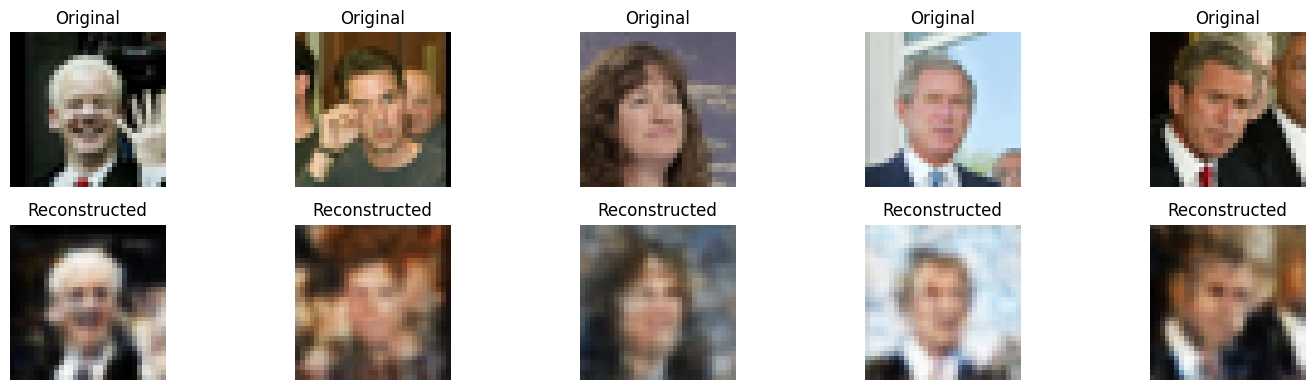

In [9]:
# 从样本中随机选择图像
num_samples = 5
random_indices = torch.randint(0, len(X_train), (num_samples,))
sample_images = X_train[random_indices]

# 通过VAE模型生成重构图像
recon_images, _, _ = model(sample_images)

# 可视化原始图像和重构图像
fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
for i in range(num_samples):
    axes[0, i].imshow(sample_images[i].permute(1, 2, 0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")
    axes[1, i].imshow(recon_images[i].detach().permute(1, 2, 0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

## Interpolation

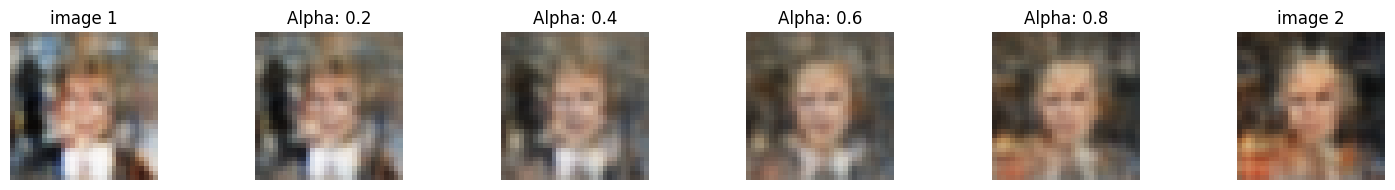

In [13]:
# 选择两个输出特征
z1, z2 = torch.randn(1, latent_dim), torch.randn(1, latent_dim)

original_image1 = model.decode(z1)
original_image2 = model.decode(z2)

# 定义插值参数
alphas = [0.2, 0.4, 0.6, 0.8]

fig, axes = plt.subplots(1, len(alphas)+2, figsize=(15, 2))

axes[0].imshow(original_image1.detach().squeeze().permute(1, 2, 0))
axes[0].set_title(f"image 1")
axes[0].axis("off")
axes[5].imshow(original_image2.detach().squeeze().permute(1, 2, 0))
axes[5].set_title(f"image 2")
axes[5].axis("off")

for i, alpha in enumerate(alphas):
    z = (1 - alpha) * z1 + alpha * z2
    generated_image = model.decode(z)
    axes[i+1].imshow(generated_image.detach().squeeze().permute(1, 2, 0))
    axes[i+1].set_title(f"Alpha: {alpha}")
    axes[i+1].axis("off")

plt.tight_layout()
plt.show()